In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
os.chdir('..')
import pandas as pd
import numpy as np
import trading.start
import trading.portfolio as portfolio
import config.settings
from time import sleep
from core.utility import *
from trading.accountcurve import *
import data.db_mongo as db
import config.portfolios
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
p = portfolio.Portfolio(instruments=config.portfolios.p_trade)
i = p.instruments
from trading.bootstrap import bootstrap
from IPython.display import FileLink, FileLinks

## How our System Works

There are three main objects that are important to us:
* Instrument
* Portfolio
* AccountCurve

## Instrument

An instrument in our system refers to a particular futures market, such as Corn or Gold.

Instruments are defined in [config/instruments.py](file/../../config/instruments.py).

When our system starts up, we instantiate an [Instrument](file/../../core/instrument.py) object for each instrument.

The instrument object:
* Holds all the properties and settings which are used by the system for calculation and rolling
* Holds all the details which are used by Interactive Brokers for trading
* Holds methods for:
  * Calculating position
  * Calculating panama prices
  * Downloading historical data
  * Bootstrapping weights for what rules work best on this instrument, based on the historical data in the system.
  
## Volatility or Standard Deviation

There are many different ways of calculating volatility. In our simple case, we assume daily returns are Gaussian distributed, and we calculate volatility as being the standard deviation of daily returns. Under this assumption, volatility and standard deviation are the same thing.

It is worth pointing out that the assumption of Gaussian returns is a dangerous one, and is only suitable for a simple system like this. There are plenty of examples when a single day move in prices has been several standard deviations.

## Panama Prices

We have a problem when we try to see trends on futures contracts. In order to apply our moving averages, we need a continuous series of prices. The contracts are seperate though, with different prices, which means there will be big jumps in the prices on the days we roll:

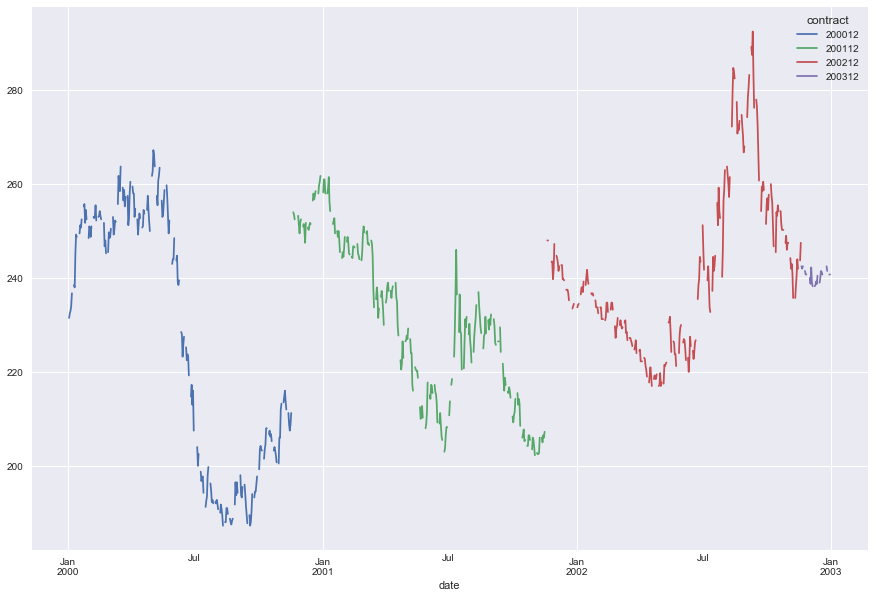

In [2]:
i['corn'].plot_contracts('2000','2002', panama=False)

We aren't interested in the absolute price, only the relative price (our moving averages effectively work on the first derivative- they are trying to find the trend). So what we can do is just move each contract up/down, so that it joins where the previous contract left off.

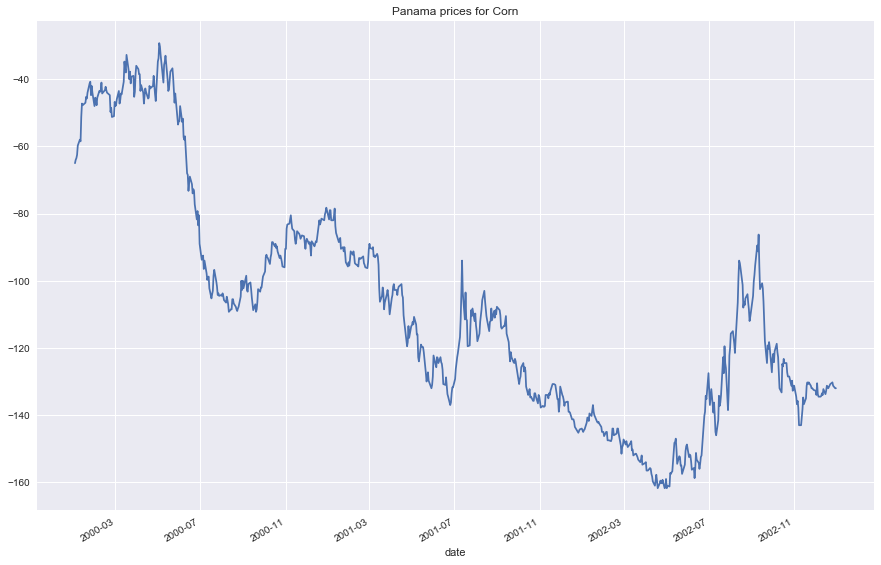

In [3]:
i['corn'].panama_prices().loc['2000':'2002'].plot(title='Panama prices for Corn')

Looking at this, we can see the absolute price on the left no longer makes any sense (it's negative). But this doesn't concern us; once we apply the moving average to this, it becomes irrelvant. In this way, we can now measure the trend across contracts.

There are various more advanced time-weighted versions that can preserve the price, but we don't need these. The simple method we use here is known as **Panama stitching**.

## Forecasts

We apply our forecasts to this data use `Instrument.forecasts()`.

For Corn, we can see we have several variations of the EWMAC rule, and another rule, carry_next (to be discussed in a later chapter).

In [4]:
i['corn'].forecasts()

,ewmac8,ewmac16,ewmac32,ewmac64,carry
date,,,,,
1993-11-26,7.564933,10.031147,9.367099,6.456318,0.799245
1993-11-29,7.342984,10.091502,9.623840,6.709447,0.874910
1993-11-30,6.963521,10.042939,9.819248,6.934971,0.943919
1993-12-01,6.805610,10.079599,10.049711,7.178643,1.007835
1993-12-02,6.835381,10.201739,10.318946,7.442906,1.069332
1993-12-03,6.622991,10.192886,10.518674,7.675724,1.127297
1993-12-06,6.425972,10.173868,10.706501,7.903860,1.184627
1993-12-07,6.361241,10.209867,10.916001,8.143450,1.242661
1993-12-08,6.346675,10.267330,11.132206,8.387592,1.305190


We need to find a way to combine these forecasts into a single forecast that we can use to make a position. In our case, we will use a weighted mean.

To determine the weights, we use bootstrapping.

## Bootstrapping rule weights

In order to find the best weights for the rules, we take samples, with replacement, of continuous sections of the price history, and we see what combination of rules works best for that sample (we optimize the Sharpe ratio, to be discussed later). We repeat this several hundred times, until we have stable weights.

In [5]:
i['corn'].bootstrap()

Bootstrap corn starting
{'annual_vol': '0.1078',
 'avg_drawdown': -0.11463082060204904,
 'avg_return_to_drawdown': 0.21413153824003053,
 'calmar': 0.0644950642006962,
 'cap': 500000,
 'gross_sharpe': 0.25176313949977686,
 'sharpe': 0.19987177297132627,
 'sortino': 0.25094556883354119,
 'time_in_drawdown': '0.8516',
 'worst_drawdown': -0.38058841012780603}


ewmac8     1.008093
ewmac16    0.882875
ewmac32    0.884973
ewmac64    1.356357
carry      0.867702
dtype: float64

#### Things to note:
* The faster EWMAC variations seem to get much lower weights. This makes sense, as they cost more to trade, and our system accounts for trading costs.
* We really want uncorrelated rules. Having two very similar rules misses the point.

In reality, we would **never** use these weights, as they've been fitted to a single instrument. Instead, we would run this process on many different instruments, spanning hundreds of years of history, and then test the generated weights on a set of test data that wasn't used for the original bootstrapping, to check we haven't overfitted.

Let's use our systems predefined weights for the next step.

In [7]:
config.strategy.rule_weights

{'buy_and_hold': 1,
 'carry': 1.0761308295764749,
 'ewmac16': 0.9456580263849846,
 'ewmac32': 0.9740415156551601,
 'ewmac64': 1.037272611390585,
 'ewmac8': 0.9668970627792554,
 'sell_and_hold': 1}

Forecast * weights = 

In [8]:
i['corn'].weighted_forecast()

date
1993-11-26     9.918410
1993-11-29    10.047668
1993-11-30    10.072994
1993-12-01    10.199734
1993-12-02    10.420929
1993-12-03    10.505216
1993-12-06    10.585983
1993-12-07    10.730055
1993-12-08    10.899273
1993-12-09    11.033996
1993-12-10    11.127585
1993-12-13    11.068446
1993-12-14    11.033230
1993-12-15    11.043588
1993-12-16    11.038567
1993-12-17    11.087031
1993-12-20    11.190705
1993-12-21    11.311969
1993-12-22    11.393358
1993-12-23    11.416230
1993-12-27    11.458517
1993-12-28    11.516816
1993-12-29    11.573539
1993-12-30    11.603347
1994-01-03    11.636904
1994-01-04    11.606941
1994-01-05    11.618855
1994-01-06    11.652513
1994-01-07    11.636565
1994-01-10    11.489579
                ...    
2018-01-11   -11.885550
2018-01-12   -11.936404
2018-01-16   -11.851634
2018-01-17   -11.578548
2018-01-18   -11.393359
2018-01-19   -11.185541
2018-01-22   -10.999277
2018-01-23   -10.870119
2018-01-24   -10.507253
2018-01-25   -10.249468
2018-01-26 

Putting this all together, we can calculate the position. This is based on an account size of £500,000 GBP. Corn is priced in USD. In `position()`, we convert our instrument return volatility to GBP, so that we can have a daily volatility target also in GBP.

Note that the contracts numbers are integers. We round these as we cannot own fractional contracts.

In [9]:
i['corn'].position()

date
1993-11-26    40.0
1993-11-29    41.0
1993-11-30    42.0
1993-12-01    43.0
1993-12-02    45.0
1993-12-03    46.0
1993-12-06    48.0
1993-12-07    50.0
1993-12-08    52.0
1993-12-09    54.0
1993-12-10    56.0
1993-12-13    54.0
1993-12-14    55.0
1993-12-15    57.0
1993-12-16    58.0
1993-12-17    60.0
1993-12-20    62.0
1993-12-21    65.0
1993-12-22    67.0
1993-12-23    69.0
1993-12-27    71.0
1993-12-28    73.0
1993-12-29    75.0
1993-12-30    77.0
1994-01-03    79.0
1994-01-04    80.0
1994-01-05    82.0
1994-01-06    85.0
1994-01-07    86.0
1994-01-10    81.0
              ... 
2018-01-11   -65.0
2018-01-12   -65.0
2018-01-16   -65.0
2018-01-17   -60.0
2018-01-18   -60.0
2018-01-19   -61.0
2018-01-22   -62.0
2018-01-23   -63.0
2018-01-24   -55.0
2018-01-25   -55.0
2018-01-26   -55.0
2018-01-29   -53.0
2018-01-30   -51.0
2018-01-31   -51.0
2018-02-01   -51.0
2018-02-02   -50.0
2018-02-05   -47.0
2018-02-06   -42.0
2018-02-07   -41.0
2018-02-08   -41.0
2018-02-09   -39.0
2018-02

The other key feature of Instrument is the roll progression, which tells us which contract we want to be in at what time. Our rolling system is not smart; it works like clockwork. Using settings from the instruments.py file, we generate a sequence which says which contract we want to be in.

In [10]:
i['corn'].roll_progression()

date
1960-12-20    196112
1960-12-21    196112
1960-12-22    196112
1960-12-23    196112
1960-12-24    196112
1960-12-25    196112
1960-12-26    196112
1960-12-27    196112
1960-12-28    196112
1960-12-29    196112
1960-12-30    196112
1960-12-31    196112
1961-01-01    196112
1961-01-02    196112
1961-01-03    196112
1961-01-04    196112
1961-01-05    196112
1961-01-06    196112
1961-01-07    196112
1961-01-08    196112
1961-01-09    196112
1961-01-10    196112
1961-01-11    196112
1961-01-12    196112
1961-01-13    196112
1961-01-14    196112
1961-01-15    196112
1961-01-16    196112
1961-01-17    196112
1961-01-18    196112
               ...  
2018-02-14    201812
2018-02-15    201812
2018-02-16    201812
2018-02-17    201812
2018-02-18    201812
2018-02-19    201812
2018-02-20    201812
2018-02-21    201812
2018-02-22    201812
2018-02-23    201812
2018-02-24    201812
2018-02-25    201812
2018-02-26    201812
2018-02-27    201812
2018-02-28    201812
2018-03-01    201812
2018-03-

## Account Curve

AccountCurve is an object that takes a list of of positions from the instruments, and calculates the returns based upon owning those positions.

How it works:
1. Get the positions, either as a parameter, or from a portfolio that's been submitted.
1. Multiply the positions by the return for that day (`prices.diff()`) and remove:
    * **Commissions** - fixed charges per contract charged by IB
    * **Spreads** - the difference between the Bid-Ask price (sometimes called, 'crossing the spread'). When we buy a contract, we pay the ask price, and when we sell it, we pay the bid price. The difference is called the 'spread'. When we buy a contract, it will show an immediate loss, as we value it at the price we can sell it for. Paying the spread is a cost of trading.
    * **Slippage** - this is difference between our expected fill price for an order, based on our model, and the actual fill price. For example, we use the settlement price for Corn yesterday to make a trade today. However, we are unlikely to be able to buy corn at the exact price of yesterday's settlement. The difference is called 'slippage'. In our code, there is a factor called `slippage_multiplier`, which is set to `0.5`. This means we expect the price we transact at to be halfway between yesterdays settlement price and today's settlement price. It's a very simple estimate, but it's better than nothing.
1. Add all these together:
    * **Position returns** - the returns from holding the portfolio that we had yesterday
    * **Transaction returns** - the returns from just today's trades, minus expenses
    
The final result is a DataFrame at `accountCurve.returns()`, which shows how much money we would have made on a daily basis.

### Important - fixed capital
AccountCurve uses fixed capital. For example, if the capital was £500,000, it will show the daily return on £500,000. It does not reinvest the returns, and it does not accumulate losses. Every day, it imagines £500,000 is invested. In reality, if there were to be a large drawdown, that could bust an account.

We do it this way because:
* As we are using leverage, we do not need £500,000 to buy £500,000 of contracts. So the money in your account has nothing to do with what you can/cannot buy.
* We do not need to 'feed forward' an account balance, we can vectorize the calculation (rather than using a loop), which makes calculating the backtest hundreds of times faster.



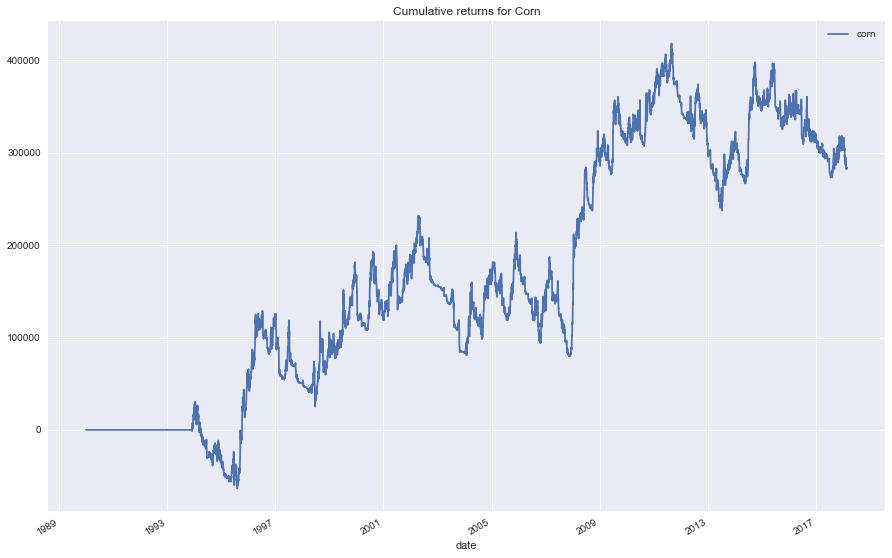

In [11]:
i['corn'].curve().returns().cumsum().plot(title='Cumulative returns for Corn')

## How the account curve calculation works on a portfolio

1. Call `Instrument.positions()` for each instrument in the portfolio, and put together in a DataFrame.
1. Calculate the volatility on that portfolio. Calculate the following normalising factor:
    $$\text{Vol Norm Factor} = \frac{\text{Daily Volatility Target}}{\text{Volatility of unnormalised instruments}}$$
    
    The purpose of this is to make the volatility of the whole portfolio hit our volatiltiy target. Remember the $\text{Daily volatility target} = \text{Annual volatility target} \div \sqrt{252}$.
1. Multiply the `Instrument.positions()` DataFrame by the volatility normalising factor.
1. Finally, apply the `chunk_trades` function, which is designed to only change the position when there is a change in volatility of >10% on a particular instrument. We do this to try and reduce trading costs.
    

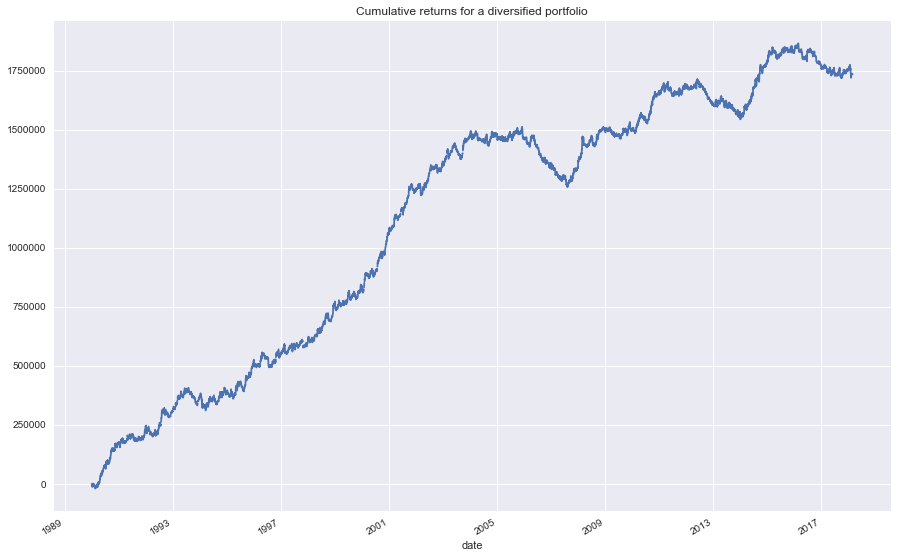

In [12]:
p.curve().returns().sum(axis=1).cumsum().plot(title='Cumulative returns for a diversified portfolio')

### The Sharpe Ratio

The accountCurve produces a number of statistics based on the returns series. The most important one is the Sharpe ratio, which is our measure of performance. It is the return we achieved, given the volatility we endured.

$$
\text{Sharpe}
=
\frac{\text{Total Returns}}{\text{Std dev of Returns}}
$$

In other words, it's the smoothness of returns. Smooth, predictible returns are the what we seek most, because we can use leverage to multiply them.

A reasonable return for a trend following strategy is about 0.3 on single instrument, and about 0.7 on a diversified portfolio.

We control the portfolio's volatility, so the expected return is:

$$
\begin{eqnarray}
\text{Expected annual return}
&=&
\text{Sharpe ratio } \times \text{Annual volatility target}\\
&=& 0.7 \times \text{25%} \\
&=& \text{17.5% } \pm \text{25%}
\end{eqnarray}
$$

So this means we can expect to have some very good years, some years with a loss, and on average, return about 17.5% a year. In this regard, performance of trend following is **mean-reverting**.

In [13]:
p.curve()

{'annual_vol': '0.1254',
 'avg_drawdown': -0.085356671645655913,
 'avg_return_to_drawdown': 1.4015053194309313,
 'calmar': 0.23483391351910637,
 'cap': 500000,
 'gross_sharpe': 0.93576890611289554,
 'sharpe': 0.86767804316533059,
 'sortino': 1.2150737071902162,
 'time_in_drawdown': '0.9311',
 'worst_drawdown': -0.50941462230740808}

In the results for the Sharpe ratio above, we can see `gross_sharpe` and `sharpe`. `gross_sharpe` does not consider the impact of commissions and spreads (but does include spreads), so we can see the impact of our trading costs on overall performance.

### How to improve Sharpe ratio

The process for improving Sharpe ratio would be roughly:
* Add more uncorrelated instruments. A diversified portfolio increases Sharpe and reduces volatility.
* Add more uncorrelated rules/strategies. The more varied and profitable rules we have, the better.
* Model costs better, and trade faster. Faster strategies usually have a higher Sharpe ratio, however, costs play a much larger role, so need to be accounted for carefully.

### Limitations of Sharpe

One problem with using the Sharpe ratio is that it penalises 'good' volatility. If our portfolio is flat, and then makes a sudden jump up, this will be great for us, but have a worse Sharpe ratio. One way to fix this is using the Sortino ratio, which only considers the downside volatility. This is something to investigate more.

## Portfolio

A Portfolio is a collection of Instruments, defined by [config/portfolios.py](file/../../config/portfolios.py).

Portfolio allows us to:
* Calculate AccountCurve for all instruments combined
* Work out ideal positions for all the instruments combined
* Run bootstrapping of rules across an entire portfolio at once
* Calculate the **frontier** - the ideal position we want to be in, and what we send to Interactive Brokers.